### Test data biz_log_summary ###

> ##### - module import

In [1]:
import pandas as pd
import numpy as np

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import plotly.express as px

import plotly.graph_objects as go

import pickle

from dateutil.parser import *

import warnings
warnings.filterwarnings('ignore')

/home/naru/.pyenv/versions/3.9.13/envs/py3.9.13/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


> ##### - set holidays #####

In [2]:
import pandas as pd
import holidays

def get_holidays( start, end ):

    series = pd.date_range( start=start, end=end, freq='D' )

    kr_holidays = holidays.KR()

    holiday_df = pd.DataFrame( columns=['ds','holiday'])
    holiday_df['ds'] = series

    holiday_df['holiday'] = holiday_df.ds.apply( lambda x: '1' if x in kr_holidays else '0' )

    holiday = holiday_df.loc[ holiday_df.holiday == '1', ].reset_index()[['holiday', 'ds']]
    holiday['holiday'] = holiday.holiday.apply( lambda x: 'holiday' if x == '1' else x )
    return holiday

> ##### Load data biz_log_summary #####

In [3]:
import pandas as pd

# 1 분 단위로 count 된 log 
# filename = '../ai-plus-test-data/logs_wyjang.csv'
# filename = '../ai-plus-test-data/logs_yjan.csv'
filename = '../ai-plus-test-data/logs_aiplus2.csv'
df = pd.read_csv( filename, sep=',', engine='python')
df.columns = [ 'ds', 'y' ]

df.ds = pd.to_datetime(df['ds'], format='%Y%m%d-%H%M')

In [4]:
df.y.sum()

48518

> ##### split data train, valid #####

In [5]:
from dateutil.parser import *
import pickle

df_train = df.loc[ df.ds < parse( '2023-06-20 00:00:00' ),]
df_valid = df.loc[ df.ds > parse( '2023-06-19 23:59:59' ) ,]

> ##### Load data test #####

In [6]:
with open( '../ai-plus-test-data/test_data.pickle', 'rb') as fr:
    df_test = pickle.load( fr )

In [63]:
fig10 = px.line( df_train, x='ds', y='y', title='Train data', render_mode='%%SVG').show()
fig11 = px.scatter( df_train, x='ds', y='y', title='Train data', render_mode='%%SVG').show()
fig20 = px.line( df_valid, x='ds', y='y', title='Valid data', render_mode='%%SVG').show()
fig21 = px.scatter( df_valid, x='ds', y='y', title='Valid data', render_mode='%%SVG').show()
fig30 = px.line( df_test, x='ds', y='y', title='Total test data', render_mode='%%SVG').show()
fig31 = px.scatter( df_test, x='ds', y='y', title='Total test data', render_mode='%%SVG').show()

In [10]:
np.sum( df.y ), np.sum( df_train.y ), np.sum( df_valid.y ), np.sum(df_test.y)
print( 
    f'''
    data : 

     - 91 일          데이터 : about {np.sum( df.y )} ea
        - 90 일 train 데이터 : about {np.sum( df_train.y )} ea
        -  1 일 valid 데이터 : about {np.sum( df_valid.y )} ea
     -  1 day    test 데이터 : 최소 100 ea
        -  1 일  test 데이터 : about {np.sum( df_test.y )} ea

    
    request -> polling : minimum 1 min / user 
    Maximum user 수와 log 에 따라 상이할 수 있음.

    - accuracy 지표 
      - 시간내 과 접속 인 비정상 log 검출 비율 80 %
      - 시간외 비정상 접속 log 검출 비율 80 %

    '''
)


    data : 

     - 91 일          데이터 : about 48518 ea
        - 90 일 train 데이터 : about 47589 ea
        -  1 일 valid 데이터 : about 929 ea
     -  1 day    test 데이터 : 최소 100 ea
        -  1 일  test 데이터 : about 963 ea

    
    request -> polling : minimum 1 min / user 
    Maximum user 수와 log 에 따라 상이할 수 있음.

    - accuracy 지표 
      - 시간내 과 접속 인 비정상 log 검출 비율 80 %
      - 시간외 비정상 접속 log 검출 비율 80 %

    


In [6]:
holiday = get_holidays( '2023-02-01', '2023-05-02' )
m = Prophet(
        
        growth='linear',
        # growth='logistic',
        # growth='flat',
    
        ## trend
        # changepoints=None,
        # n_changepoints=25,
        changepoint_range=0.9,    
        changepoint_prior_scale=0.1,
        
        # ## seasonality
        seasonality_mode='multiplicative',
        # seasonality_mode='additive', # additive
        seasonality_prior_scale=10.0, # 10
        daily_seasonality=10.0,
        weekly_seasonality=0.05,
        # daily_seasonality=False,
        # weekly_seasonality=False,
        # yearly_seasonality=False,
        
        ## holiday
        # holidays=holiday,
        holidays_prior_scale=10,
        
        ## Others
        # interval_width = 0.95,        
        # interval_width = 0.99,        
        # mcmc_samples = 300,
        # uncertainty_samples=1000,
    
)

tr = df_train.set_index('ds').resample( '1T' ).mean().reset_index()
# tr.y.fillna(0, inplace=True)
tr["is_weekend"] = tr["ds"].apply( lambda x: 1 if x.weekday in (5, 6) else 0 )
m.add_seasonality(name='weekend_daily', period=1, fourier_order=5, condition_name='is_weekend', prior_scale=10 )
m.fit(tr)

# future = m.make_future_dataframe(periods=24 * 60, freq='min')
# future["is_weekend"] = future["ds"].apply( lambda x: 1 if x.weekday in (5, 6) else 0 )
# pred = m.predict( future )

## 
# df_test["is_weekend"] = df_test["ds"].apply( lambda x: 1 if x.weekday in (5, 6) else 0 )

# df_test[['ds', 'y', 'is_weekend']], df_test[['true',]]

# pred = m.predict( df_test[['ds', 'y', 'is_weekend']] )

##
df_valid["is_weekend"] = df_valid["ds"].apply( lambda x: 1 if x.weekday in (5, 6) else 0 )

# df_valid[['ds', 'y', 'is_weekend']], df_valid[['true',]]
df_valid[['ds', 'y', 'is_weekend']]

pred = m.predict( df_valid[['ds', 'y', 'is_weekend']] )

17:42:45 - cmdstanpy - INFO - Chain [1] start processing
17:42:52 - cmdstanpy - INFO - Chain [1] done processing


In [7]:
pred.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'daily', 'daily_lower', 'daily_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper',
       'weekend_daily', 'weekend_daily_lower', 'weekend_daily_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yhat'],
      dtype='object')

In [8]:
pred

ds     trend  yhat_lower  yhat_upper  trend_lower  \
0   2023-06-20 03:40:00  5.811187   10.231287   12.823495     5.811187   
1   2023-06-20 04:42:00  5.811033    7.689423   10.376650     5.811033   
2   2023-06-20 05:44:00  5.810879   -7.228445   -4.347282     5.810879   
3   2023-06-20 06:46:00  5.810725   20.486722   23.178306     5.810725   
4   2023-06-20 07:48:00  5.810571   15.755619   18.312889     5.810571   
..                  ...       ...         ...         ...          ...   
404 2023-06-20 19:26:00  5.808837   16.679309   19.308918     5.808829   
405 2023-06-20 20:26:00  5.808688   15.239134   17.953037     5.808680   
406 2023-06-20 21:26:00  5.808539   -7.156326   -4.643457     5.808531   
407 2023-06-20 22:26:00  5.808390   10.184569   12.887525     5.808381   
408 2023-06-20 23:26:00  5.808240    8.173892   10.800555     5.808232   

     trend_upper     daily  daily_lower  daily_upper  multiplicative_terms  \
0       5.811187  0.977479     0.977479     0.977479              0.977479   
1       5.811033  0.553956     0.553956     0.553956              0.553956   
2       5.810879 -1.997012    -1.997012    -1.997012             -1.997012   
3       5.810725  2.752507     2.752507     2.752507              2.752507   
4       5.810571  1.931888     1.931888     1.931888              1.931888   
..           ...       ...          ...          ...                   ...   
404     5.808837  2.104126     2.104126     2.104126              2.104126   
405     5.808688  1.858621     1.858621     1.858621              1.858621   
406     5.808539 -2.018104    -2.018104    -2.018104             -2.018104   
407     5.808390  0.973882     0.973882     0.973882              0.973882   
408     5.808240  0.631090     0.631090     0.631090              0.631090   

     multiplicative_terms_lower  multiplicative_terms_upper  weekend_daily  \
0                      0.977479                    0.977479            0.0   
1                      0.553956                    0.553956            0.0   
2                     -1.997012                   -1.997012            0.0   
3                      2.752507                    2.752507            0.0   
4                      1.931888                    1.931888            0.0   
..                          ...                         ...            ...   
404                    2.104126                    2.104126            0.0   
405                    1.858621                    1.858621            0.0   
406                   -2.018104                   -2.018104            0.0   
407                    0.973882                    0.973882            0.0   
408                    0.631090                    0.631090            0.0   

     weekend_daily_lower  weekend_daily_upper  additive_terms  \
0                    0.0                  0.0             0.0   
1                    0.0                  0.0             0.0   
2                    0.0                  0.0             0.0   
3                    0.0                  0.0             0.0   
4                    0.0                  0.0             0.0   
..                   ...                  ...             ...   
404                  0.0                  0.0             0.0   
405                  0.0                  0.0             0.0   
406                  0.0                  0.0             0.0   
407                  0.0                  0.0             0.0   
408                  0.0                  0.0             0.0   

     additive_terms_lower  additive_terms_upper       yhat  
0                     0.0                   0.0  11.491500  
1                     0.0                   0.0   9.030091  
2                     0.0                   0.0  -5.793518  
3                     0.0                   0.0  21.804787  
4                     0.0                   0.0  17.035944  
..                    ...                   ...        ...  
404                   0.0                   0.0  1

In [9]:
pred_dday = pred.loc[pred.ds > parse( '2023-05-02 00:00:00' ), ]
pred_dday = pd.concat([df_valid.set_index('ds')[['y',]], pred_dday.set_index('ds')[['yhat','yhat_lower','yhat_upper']]], axis=1)
pred_dday = pred_dday.reset_index()
pred_dday

ds  y       yhat  yhat_lower  yhat_upper
0   2023-06-20 03:40:00  2  11.491500   10.231287   12.823495
1   2023-06-20 04:42:00  1   9.030091    7.689423   10.376650
2   2023-06-20 05:44:00  1  -5.793518   -7.228445   -4.347282
3   2023-06-20 06:46:00  1  21.804787   20.486722   23.178306
4   2023-06-20 07:48:00  2  17.035944   15.755619   18.312889
..                  ... ..        ...         ...         ...
404 2023-06-20 19:26:00  2  18.031361   16.679309   19.308918
405 2023-06-20 20:26:00  1  16.604838   15.239134   17.953037
406 2023-06-20 21:26:00  3  -5.913698   -7.156326   -4.643457
407 2023-06-20 22:26:00  2  11.465075   10.184569   12.887525
408 2023-06-20 23:26:00  2   9.473765    8.173892   10.800555

[409 rows x 5 columns]

In [10]:
pred.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'daily', 'daily_lower', 'daily_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper',
       'weekend_daily', 'weekend_daily_lower', 'weekend_daily_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yhat'],
      dtype='object')

<Axes: >

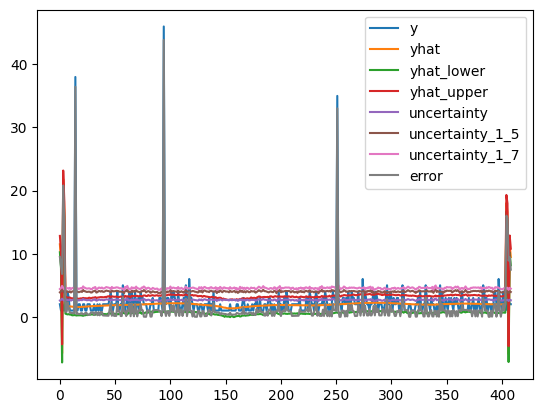

In [11]:
pred_dday['error'] = (pred_dday['y'] - pred_dday['yhat']).abs()
pred_dday['uncertainty'] = pred_dday['yhat_upper'] - pred_dday['yhat_lower']
pred_dday['uncertainty_1_5'] = pred_dday['uncertainty'] * 1.5
pred_dday['uncertainty_1_7'] = pred_dday['uncertainty'] * 1.7

pred_dday[['y', 'yhat', 'yhat_lower', 'yhat_upper', 'uncertainty', 'uncertainty_1_5', 'uncertainty_1_7', 'error', ]].plot()

# pred_dday['error'].plot()

In [17]:
fig = px.line(pred_dday, x='ds', y=pred_dday.columns, title=f'Features', render_mode='%%SVG')
fig.show()

fig.write_image("../images/Features.svg")

In [117]:
# px.line(pred_dday, x='ds', y=pred_dday.columns, title=f'graph', render_mode='%%SVG').show()
# px.scatter(pred_dday, x='ds', y=pred_dday.columns, title=f'graph', render_mode='%%SVG').show()

px.scatter(pred_dday, x='ds', y=['y', 'yhat', 'yhat_upper', 'yhat_lower'], title=f'Predict & Real values', render_mode='%%SVG').show()

px.scatter(pred_dday, x='ds', y=['error', 'uncertainty', 'uncertainty_1_5', 'uncertainty_1_7', ], title=f'Predict & Real values', render_mode='%%SVG').show()


In [107]:
# pred_dday['error'] = (pred_dday['y'].abs() - pred_dday['yhat'].abs() ).abs()
# pred_dday['uncertainty'] = pred_dday['yhat_upper'] - pred_dday['yhat_lower']
# pred_dday['uncertainty_1_5'] = pred_dday['uncertainty'] * 1.5

anomal = pred_dday.copy()
# anomal['anomaly'] = anomal.apply(lambda x: 1 if  ( x.y - x.pow_yhat_up + np.abs(x.yhat_lower)  ) > 0  else 0, axis = 1)
# anomal['anomaly'] = anomal.apply(lambda x: 1 if  ( x.y - x.pow_yhat_up  ) > 0  else 0, axis = 1)
anomal['anomaly'] = anomal.apply(lambda x: '1' if x.error > (x.uncertainty * 1.5) else '0', axis = 1)
anomal[anomal.anomaly == '1']

ds   y       yhat  yhat_lower  yhat_upper      error  \
0   2023-06-20 03:40:00   2  11.491500   10.132593   12.815573   9.491500   
1   2023-06-20 04:42:00   1   9.030091    7.680536   10.326666   8.030091   
2   2023-06-20 05:44:00   1  -5.793518   -7.017676   -4.452531   6.793518   
3   2023-06-20 06:46:00   1  21.804787   20.503252   23.185551  20.804787   
4   2023-06-20 07:48:00   2  17.035944   15.663008   18.425704  15.035944   
14  2023-06-20 09:15:00  38   1.557619    0.174748    2.821110  36.442381   
94  2023-06-20 11:04:00  46   2.125665    0.771868    3.481486  43.874335   
117 2023-06-20 11:31:00   6   2.091902    0.777995    3.314669   3.908098   
251 2023-06-20 14:56:00  35   1.979227    0.642738    3.252077  33.020773   
404 2023-06-20 19:26:00   2  18.031361   16.741295   19.443623  16.031361   
405 2023-06-20 20:26:00   1  16.604838   15.316572   17.870281  15.604838   
406 2023-06-20 21:26:00   3  -5.913698   -7.151662   -4.492148   8.913698   
407 2023-06-20 22:26:00   2  11.465075   10.131679   12.864146   9.465075   
408 2023-06-20 23:26:00   2   9.473765    8.226076   10.779079   7.473765   

     uncertainty  uncertainty_1_5  uncertainty_1_7 anomaly  
0       2.682980         4.024470         4.561066       1  
1       2.646130         3.969195         4.498421       1  
2       2.565145         3.847718         4.360747       1  
3       2.682299         4.023449         4.559908       1  
4       2.762695         4.144043         4.696582       1  
14      2.646362         3.969544         4.498816       1  
94      2.709618         4.064427         4.606350       1  
117     2.536674         3.805010         4.312345       1  
251     2.609339         3.914008         4.435876       1  
404     2.702329         4.053493         4.593959       1  
405     2.553709         3.830564         4.341305       1  
406     2.659513         3.989270         4.521173       1  
407     2.732466         4.098700         4.645193       1  
408     2.553003         3.829505         4.340106       1

In [118]:
px.scatter( anomal.reset_index(), x='ds', y='y', color='anomaly', 
            color_discrete_sequence=["red", "blue"],
            title=f'Anomaly values',
            render_mode='%%SVG'
          ).show()

> ##### Get confusion matrix #####

In [82]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics

import matplotlib.pyplot as plt

confusion_matrix( anomal.true, anomal.anomaly )
# target_names = ['class 0', 'class 1', 'class 2']
# print(classification_report(anomal.true, anomal.anomaly, target_names=target_names))

cm = confusion_matrix( anomal.true, anomal.anomaly, labels=[1, 0])

print(cm)

px.imshow(  cm,
            x=['TP', 'FN'],
            y=['FP', 'TN'],
            text_auto=True ).show()


print(
f'''
accuracy : {metrics.accuracy_score(anomal.true, anomal.anomaly)}

precision : {metrics.precision_score(anomal.true, anomal.anomaly)}

recall : {metrics.recall_score(anomal.true, anomal.anomaly)}

f1 : {metrics.f1_score(anomal.true, anomal.anomaly)}
'''
)

dict({
    'accuracy' : metrics.accuracy_score(anomal.true, anomal.anomaly),
    'precision' : metrics.precision_score(anomal.true, anomal.anomaly),
    'recall' : metrics.recall_score(anomal.true, anomal.anomaly),
    'f1' : metrics.f1_score(anomal.true, anomal.anomaly),
})

[[20  0]
 [ 0 70]]



accuracy : 1.0

precision : 1.0

recall : 1.0

f1 : 1.0



{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}

> ##### Test run_to_predict ##### ( view confusion matrix )

In [85]:
from sklearn import metrics

def run_to_predict(  train, test, period :str, holiday ):  
    
    m = Prophet(
            
            growth='linear',
            # growth='logistic',
            # growth='flat',
        
            ## trend
            # changepoints=None,
            # n_changepoints=25,
            changepoint_range=0.9,    
            changepoint_prior_scale=0.1,
            
            # ## seasonality
            seasonality_mode='multiplicative',
            # seasonality_mode='additive', # additive
            seasonality_prior_scale=10.0, # 10
            daily_seasonality=10.0,
            weekly_seasonality=0.05,
            # daily_seasonality=False,
            # weekly_seasonality=False,
            # yearly_seasonality=False,
            
            ## holiday
            holidays=holiday,
            holidays_prior_scale=10,
            
            ## Others
            # interval_width = 0.95,        
            # interval_width = 0.99,        
            # mcmc_samples = 300,
            # uncertainty_samples=1000,
        
    )

    # m.add_seasonality(name='weekday_daily', period=1, fourier_order=5, condition_name='is_weekday', prior_scale=10 )
    # m.add_seasonality(name='weekend_daily', period=1, fourier_order=5, condition_name='is_weekend', prior_scale=10 )
    
    # m.add_seasonality(name='weekday_daily', period=1, fourier_order=4)
    # m.add_seasonality(name='weekend_daily', period=1, fourier_order=4 )
    # m.add_seasonality(name='monthly', period=1, fourier_order=5)

    ######################

    tr = train.set_index('ds').resample( '1T' ).mean().reset_index()
    tr.y.fillna(0, inplace=True)
    tr["is_weekend"] = tr["ds"].apply( lambda x: 1 if x.weekday in (5, 6) else 0 )
    m.add_seasonality(name='weekend_daily', period=1, fourier_order=5, condition_name='is_weekend', prior_scale=10 )
    m.fit(tr)

    # future = m.make_future_dataframe(periods=24 * 60, freq='min')
    # future["is_weekend"] = future["ds"].apply( lambda x: 1 if x.weekday in (5, 6) else 0 )
    # pred = m.predict( future )

    test["is_weekend"] = test["ds"].apply( lambda x: 1 if x.weekday in (5, 6) else 0 )

    pred = m.predict( test[['ds', 'y', 'is_weekend']] )

    pred_dday = pred.loc[pred.ds > parse( '2023-05-02 00:00:00' ), ]
    pred_dday = pd.concat([test.set_index('ds')[['y', 'true']], pred_dday.set_index('ds')[['yhat','yhat_lower','yhat_upper']]], axis=1)
    pred_dday.reset_index( inplace=True )

    ######################
    pred_dday['pow_yhat_up'] = np.power( pred_dday['yhat_upper'], 4 ) * 1.5
    pred_dday['pow_yhat_up_yhat_lower'] = pred_dday.pow_yhat_up - np.abs(pred_dday.yhat_lower)

    anomal = pred_dday.copy()
    anomal['anomaly'] = anomal.apply(lambda x: 1 if  ( x.y - x.pow_yhat_up + np.abs(x.yhat_lower)  ) > 0  else 0, axis = 1)
    
    anomal[anomal.anomaly == 1]

    ######################

    confuse_metrics = dict({
        'accuracy' : metrics.accuracy_score(anomal.true, anomal.anomaly),
        'precision' : metrics.precision_score(anomal.true, anomal.anomaly),
        'recall' : metrics.recall_score(anomal.true, anomal.anomaly),
        'f1' : metrics.f1_score(anomal.true, anomal.anomaly),
    })
    
    return {
                'descript' : f'{period} tick test',
                'result'   : anomal,
                'model'    : m,
                'accuracy' : confuse_metrics,
            }

> ##### >>> Run >>> ##### ( view confusion matrix )

In [86]:
holiday = get_holidays( '2023-02-01', '2023-05-02' )
# result_dict = run_to_predict(df_train, df_valid, '1T', holiday)
result_dict = run_to_predict(df_train, df_test, '1T', holiday)

20:20:47 - cmdstanpy - INFO - Chain [1] start processing
20:22:21 - cmdstanpy - INFO - Chain [1] done processing


In [87]:
result_dict.keys()

dict_keys(['descript', 'result', 'model', 'accuracy'])

In [89]:
result = result_dict['result']
px.scatter(result.reset_index(), x='ds', y='y', color='anomaly').show()
result

ds  y  true      yhat  yhat_lower  yhat_upper   
0  2023-05-02 02:39:00  7     1 -0.038293   -1.169166    1.053199  \
1  2023-05-02 03:18:00  1     1 -0.009626   -1.090565    1.082419   
2  2023-05-02 06:22:00  2     1  0.015576   -1.026177    1.034525   
3  2023-05-02 07:02:00  4     1 -0.044505   -1.094510    0.939949   
4  2023-05-02 07:56:00  3     1  0.044020   -0.961894    1.048165   
..                 ... ..   ...       ...         ...         ...   
85 2023-05-02 19:34:00  2     1 -0.068103   -1.070355    1.052906   
86 2023-05-02 20:27:00  9     1  0.021265   -1.122468    1.040378   
87 2023-05-02 21:09:00  4     1 -0.004045   -1.063821    1.053746   
88 2023-05-02 21:23:00  7     1 -0.024919   -1.160442    1.133774   
89 2023-05-02 22:38:00  4     1 -0.002604   -1.052472    1.071551   

    pow_yhat_up  pow_yhat_up_yhat_lower  anomaly  
0      1.845584                0.676417        1  
1      2.059077                0.968512        1  
2      1.718128                0.691951        1  
3      1.170869                0.076359        1  
4      1.810548                0.848654        1  
..          ...                     ...      ...  
85     1.843527                0.773172        1  
86     1.757338                0.634870        1  
87     1.849415                0.785594        1  
88     2.478544                1.318102        1  
89     1.977622                0.925150        1  

[90 rows x 9 columns]

> ##### Test run_to_predict ##### ( production )

In [56]:

# Get Holidays  - as seasonality
def run_to_predict(  train, test, period :str, holiday=None ):   
    
    m = Prophet(
            
            growth='linear',
            # growth='logistic',
            # growth='flat',
        
            ## trend
            # changepoints=None,
            # n_changepoints=25,
            changepoint_range=0.9,    
            changepoint_prior_scale=0.1,
            
            # ## seasonality
            seasonality_mode='multiplicative',
            # seasonality_mode='additive', # additive
            seasonality_prior_scale=10.0, # 10
            daily_seasonality=10.0,
            weekly_seasonality=0.05,
            # daily_seasonality=False,
            # weekly_seasonality=False,
            # yearly_seasonality=False,
            
            ## holiday
            holidays=holiday,
            holidays_prior_scale=10,
            
            ## Others
            # interval_width = 0.95,        
            # interval_width = 0.99,        
            # mcmc_samples = 300,
            # uncertainty_samples=1000,
        
    )

    ######################

    tr = train.set_index('ds').resample( period ).mean().reset_index()
    tr.y.fillna(0, inplace=True)
    tr["is_weekend"] = tr["ds"].apply( lambda x: 1 if x.weekday in (5, 6) else 0 )
    m.add_seasonality(name='weekend_daily', period=1, fourier_order=5, condition_name='is_weekend', prior_scale=10 )
    m.fit(tr)

    # future = m.make_future_dataframe(periods=24 * 60, freq='min')
    # future["is_weekend"] = future["ds"].apply( lambda x: 1 if x.weekday in (5, 6) else 0 )
    # pred = m.predict( future )

    test["is_weekend"] = test["ds"].apply( lambda x: 1 if x.weekday in (5, 6) else 0 )

    pred = m.predict( test[['ds', 'y', 'is_weekend']] )
    
    pred_dday = pd.concat([test.set_index('ds')['y'], pred.set_index('ds')[['yhat','yhat_lower','yhat_upper']]], axis=1)
    pred_dday.reset_index( inplace=True )

    ######################
    pred_dday['pow_yhat_up'] = np.power( pred_dday['yhat_upper'], 4 ) * 1.5
    pred_dday['pow_yhat_up_yhat_lower'] = pred_dday.pow_yhat_up - np.abs(pred_dday.yhat_lower)

    anomal = pred_dday.copy()
    anomal['anomaly'] = anomal.apply(lambda x: 1 if  ( x.y - x.pow_yhat_up + np.abs(x.yhat_lower)  ) > 0  else 0, axis = 1)
    
    anomal[anomal.anomaly == 1]

    ######################

    # ats_data.ds = ats_data.ds.apply( lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))
    # ats_data = anomal[anomal.anomaly == 1].reset_index()
    # ats_data.ds.apply( lambda x: x.strftime('%Y-%m-%d %H:%M:%S')).values
    ats_data = anomal[anomal.anomaly == 1].ds.apply( lambda x: x.strftime('%Y-%m-%d %H:%M:%S')).values
    
    return {
                'result'   : ats_data,
                'anomal'   : anomal
            }
# -------------------


> ##### >>> Run >>> ( production )

In [57]:
import time
import datetime

start = time.time()


holiday = get_holidays( '2023-02-01', '2023-05-02' )
# result_dict = run_to_predict(df_train, df_valid, '1T', holiday)
result_dict = run_to_predict(df_train, df_valid, '1T', holiday)


end = time.time()

sec = (end - start)
result = datetime.timedelta(seconds=sec)
print(result)

01:25:16 - cmdstanpy - INFO - Chain [1] start processing
01:26:53 - cmdstanpy - INFO - Chain [1] done processing


0:01:44.504630


In [51]:
result_dict['result']

array(['2023-06-19 03:25:00', '2023-06-19 04:27:00',
       '2023-06-19 05:29:00', '2023-06-19 06:31:00',
       '2023-06-19 07:33:00', '2023-06-19 17:59:00',
       '2023-06-19 18:27:00', '2023-06-19 19:09:00',
       '2023-06-19 20:09:00', '2023-06-19 21:09:00',
       '2023-06-19 22:09:00', '2023-06-19 23:09:00'], dtype=object)

In [41]:
result_dict.keys()

dict_keys(['result'])

In [60]:
result = result_dict['result']
anomal = result_dict['anomal']

result
anomal[anomal.anomaly == 1]

ds   y      yhat  yhat_lower  yhat_upper  pow_yhat_up   
0   2023-06-19 03:25:00   1 -0.001086   -0.890865    0.924983     1.098059  \
1   2023-06-19 04:27:00   3 -0.014728   -0.982227    0.930860     1.126234   
2   2023-06-19 05:29:00   1 -0.036251   -0.918472    0.871300     0.864493   
3   2023-06-19 06:31:00   3  0.033496   -0.913469    0.999203     1.495222   
4   2023-06-19 07:33:00   3 -0.107960   -1.046026    0.838408     0.741160   
418 2023-06-19 17:59:00  43  0.855020   -0.035313    1.785392    15.241413   
419 2023-06-19 18:27:00  44  0.264862   -0.641965    1.215194     3.270949   
420 2023-06-19 19:09:00   1 -0.147118   -1.043589    0.746216     0.465103   
421 2023-06-19 20:09:00   3  0.022086   -0.922550    0.945585     1.199205   
422 2023-06-19 21:09:00   3 -0.013174   -0.959853    0.902690     0.995970   
423 2023-06-19 22:09:00   3 -0.043319   -0.980590    0.861213     0.825152   
424 2023-06-19 23:09:00   3  0.017574   -0.901994    0.919635     1.072884   

     pow_yhat_up_yhat_lower  anomaly  
0                  0.207194        1  
1                  0.144007        1  
2                 -0.053980        1  
3                  0.581753        1  
4                 -0.304865        1  
418               15.206100        1  
419                2.628983        1  
420               -0.578487        1  
421                0.276655        1  
422                0.036117        1  
423               -0.155439        1  
424                0.170890        1

In [70]:
result = result_dict['anomal']
px.scatter(result.reset_index(), x='ds', y='y', color='anomaly').show()
result[305:]

ds   y      yhat  yhat_lower  yhat_upper  pow_yhat_up   
305 2023-06-19 15:46:00   1  1.858658    0.917845    2.824940    95.527411  \
306 2023-06-19 15:48:00   4  1.863336    0.898427    2.776722    89.170437   
307 2023-06-19 15:49:00   1  1.865841    0.916245    2.837878    97.289571   
308 2023-06-19 15:50:00  37  1.868452    0.918571    2.764793    87.647973   
309 2023-06-19 15:51:00   1  1.871167    0.872075    2.781109    89.735262   
..                  ...  ..       ...         ...         ...          ...   
420 2023-06-19 19:09:00   1 -0.147118   -1.043589    0.746216     0.465103   
421 2023-06-19 20:09:00   3  0.022086   -0.922550    0.945585     1.199205   
422 2023-06-19 21:09:00   3 -0.013174   -0.959853    0.902690     0.995970   
423 2023-06-19 22:09:00   3 -0.043319   -0.980590    0.861213     0.825152   
424 2023-06-19 23:09:00   3  0.017574   -0.901994    0.919635     1.072884   

     pow_yhat_up_yhat_lower  anomaly  
305               94.609567        0  
306               88.272010        0  
307               96.373325        0  
308               86.729402        0  
309               88.863188        0  
..                      ...      ...  
420               -0.578487        1  
421                0.276655        1  
422                0.036117        1  
423               -0.155439        1  
424                0.170890        1  

[120 rows x 8 columns]

> ##### Search space #####   
- get best seasonality 

In [ ]:

import itertools
from prophet.diagnostics import cross_validation, performance_metrics

def get_validation_values():

   holiday_df = get_holidays( '2023-02-01', '2023-05-02' )

   search_space = {
   'changepoint_prior_scale': [0.05, 0.1, 0.5, 1.0, 5.0, 10.0],
   'seasonality_prior_scale': [0.05, 0.1, 1.0, 10.0],
   'holidays_prior_scale': [0.05, 0.1, 1.0, 10.0],
   #  'seasonality_mode': ['additive', 'multiplicative'],
   'seasonality_mode': ['additive', ],
   'holidays': [holiday_df]
   }

   param_combined = [dict(zip(search_space.keys(), v)) for v in itertools.product(*search_space.values())]

   mapes = []
   for param in param_combined:
      print('params', param)
      _m = Prophet(**param)
   #  if regressors is not None:
   #    for regressor in regressors:
   #      _m.add_regressor(regressor)

      _m.fit(df)
      _cv_df = cross_validation(_m, horizon='24 hours', parallel='threads')
      _df_p = performance_metrics(_cv_df, rolling_window=1)
      mapes.append(_df_p['mape'].values[0])

   tuning_results = pd.DataFrame(param_combined)
   tuning_results['mapes'] = mapes

### 자동 검증 ###

> ##### Import 모듈 #####

In [1]:
import pandas as pd
import numpy as np

from prophet import Prophet

from sklearn.metrics import confusion_matrix
from sklearn import metrics

import plotly.express as px

from dateutil.parser import *

import datetime

import time

import warnings
warnings.filterwarnings('ignore')

/home/naru/.pyenv/versions/3.9.13/envs/py3.9.13/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


> ##### Model Training and predict #####

In [2]:

# Get Holidays  - as seasonality
def run_to_predict(  train, test, period :str, holiday=None ):   
    
    # start time
    start_time = time.time()  
    
    m = Prophet(
            
            growth='linear',
            # growth='logistic',
            # growth='flat',
        
            ## trend
            # changepoints=None,
            # n_changepoints=25,
            changepoint_range=0.9,    
            changepoint_prior_scale=0.1,
            
            # ## seasonality
            seasonality_mode='multiplicative',
            # seasonality_mode='additive', # additive
            seasonality_prior_scale=10.0, # 10
            daily_seasonality=10.0,
            weekly_seasonality=0.05,
            # daily_seasonality=False,
            # weekly_seasonality=False,
            # yearly_seasonality=False,
            
            ## holiday
            # holidays=holiday,
            holidays_prior_scale=10,
            
            ## Others
            # interval_width = 0.95,        
            # interval_width = 0.99,        
            # mcmc_samples = 300,
            # uncertainty_samples=1000,
        
    )

    ######################

    tr = train.set_index('ds').resample( period ).mean().reset_index()
    tr.y.fillna(0, inplace=True)
    tr["is_weekend"] = tr["ds"].apply( lambda x: 1 if x.weekday in (5, 6) else 0 )
    m.add_seasonality(name='weekend_daily', period=1, fourier_order=5, condition_name='is_weekend', prior_scale=10 )
    m.fit(tr)

    # future = m.make_future_dataframe(periods=24 * 60, freq='min')
    # future["is_weekend"] = future["ds"].apply( lambda x: 1 if x.weekday in (5, 6) else 0 )
    # pred = m.predict( future )

    test["is_weekend"] = test["ds"].apply( lambda x: 1 if x.weekday in (5, 6) else 0 )

    pred = m.predict( test[['ds', 'y', 'is_weekend']] )
    
    # pred_dday = pd.concat([test.set_index('ds')['y'], pred.set_index('ds')[['yhat','yhat_lower','yhat_upper']]], axis=1)
    pred_dday = pd.concat([test.set_index('ds')[['y', 'true']], pred.set_index('ds')[['yhat','yhat_lower','yhat_upper']]], axis=1)
    pred_dday.reset_index( inplace=True )

    ######################
    pred_dday['pow_yhat_up'] = np.power( pred_dday['yhat_upper'], 4 ) * 1.5
    pred_dday['pow_yhat_up_yhat_lower'] = pred_dday.pow_yhat_up - np.abs(pred_dday.yhat_lower)

    anomal = pred_dday.copy()
    anomal['anomaly'] = anomal.apply(lambda x: 1 if  ( x.y - x.pow_yhat_up + np.abs(x.yhat_lower)  ) > 0  else 0, axis = 1)
    
    anomal[anomal.anomaly == 1]

    ######################

    # ats_data.ds = ats_data.ds.apply( lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))
    # ats_data = anomal[anomal.anomaly == 1].reset_index()
    # ats_data.ds.apply( lambda x: x.strftime('%Y-%m-%d %H:%M:%S')).values
    ats_data = anomal[anomal.anomaly == 1].ds.apply( lambda x: x.strftime('%Y-%m-%d %H:%M:%S')).values

    end_time = time.time()
    
    return {
                'result'   : ats_data,
                'anomal'   : anomal,
                                
                'accuracy' : metrics.accuracy_score(anomal.true, anomal.anomaly),
                'precision' : metrics.precision_score(anomal.true, anomal.anomaly),
                'recall' : metrics.recall_score(anomal.true, anomal.anomaly),
                'f1' : metrics.f1_score(anomal.true, anomal.anomaly),
                'cm_heatmap' : confusion_matrix( anomal.true, anomal.anomaly, labels=[1, 0]),

                'start_time' : start_time,
                'end_time' : end_time,
                'evaluation_time' : end_time - start_time,
            }
# -------------------


> ##### add column 'real anomal' #####

In [3]:
def check_real_anomal( df ):
    # 칼람 츠기
    df['true'] = 0

    # 9 시 이전, 18시 이후 anomal 실재값 표기
    indexes = df[(df['ds'] < '2023-06-20 09:00:00') | (df['ds'] > '2023-06-20 17:59:59')].index
    df.loc[indexes, ['true',]] = 1

    # 근무시간중 과다접속 anomal 실재값 표기
    indexes = df.sort_values( 'y', ascending=False )[:3].index
    df.loc[indexes, ['true',]] = 1

    return df

> ##### Load data ( 10 user ) #####

In [4]:
def load_data( date, filename ):
    # 1 분 단위로 count 된 log 
    df = pd.read_csv( filename, sep=',', engine='python')
    df.columns = [ 'ds', 'y' ]

    df.ds = pd.to_datetime(df['ds'], format='%Y%m%d-%H%M')

    # df_train = df.loc[ df.ds < parse( '2023-06-20 00:00:00' ),]
    # df_test = df.loc[ df.ds > parse( '2023-06-19 23:59:59' ) ,]

    before = date - datetime.timedelta(seconds=1)

    df_train = df.loc[ df.ds < date,]
    df_test = df.loc[ df.ds > before ,]
    
    # anomal 실재값 column 추가
    df_test = check_real_anomal( df_test )

    train_line = px.line( df_train, x='ds', y='y', title='Train data', render_mode='%%SVG').show()
    train_scatter = px.scatter( df_train, x='ds', y='y', title='Train data', render_mode='%%SVG').show()
    test_line = px.line( df_test, x='ds', y='y', title='Total test data', render_mode='%%SVG').show()
    test_scatter = px.scatter( df_test, x='ds', y='y', title='Total test data', render_mode='%%SVG').show()

    return {
            'train' : {
                'data' : df_train,
                'graph' : {
                    'line' : train_line,
                    'scatter' : train_scatter,
                }
            },
            'test' : {
                'data' : df_test,
                'graph' : {
                    'line' : test_line,
                    'scatter' : test_scatter,
                }
            },
        }


> ##### >>> Run >>> ( Verification )

>> loads users logs

In [5]:
filenames = [f'../ai-plus-test-data/logs_aiplus{number}.csv' for number in range( 1, 11 )]
    
# result_dict = run_to_predict(df_train, df_test, '1T', holiday)

date = parse( '2023-06-20' )

load_data_list = [ load_data( date, filename ) for filename in filenames ]

In [6]:
print(
    f'''
    - data 1              : {load_data_list[0].keys() }
    - data, graph         : {load_data_list[0].get('train').keys()}
    - graph line, scatter : {load_data_list[0].get('train').get('graph').keys()}
    - graph usage         : load_data_list[0].get('train').get('graph').('line').show()
    ''')


    - data 1              : dict_keys(['train', 'test'])
    - data, graph         : dict_keys(['data', 'graph'])
    - graph line, scatter : dict_keys(['line', 'scatter'])
    - graph usage         : load_data_list[0].get('train').get('graph').('line').show()
    


>> predict and gets model, confusion_matrix, anomal_data

In [7]:
predict_result = [ run_to_predict(  user.get('train').get('data'), user.get('test').get('data'), '1T' ) for user in load_data_list ]
    

15:31:36 - cmdstanpy - INFO - Chain [1] start processing


KeyboardInterrupt: 

> ##### End Of File #####